# URL clustering based on similarity

- urls_df = full dataset
- urls_tdf = full dataset transformed
- urls_tsdf = sampled dataset transformed

## Imports & Helper functions

### Imports

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

### Helper functions

In [30]:
from polyleven import levenshtein


class SklearnStringTrick:
    """
    String clustering trick shown at:
        https://scikit-learn.org/0.16/faq.html#how-do-i-deal-with-string-data-or-trees-graphs

    Class structure allows for method reuse over distinct data

    """

    def __init__(self, dataset=[]):
        self.dataset = dataset

    def lev_dist_sklearn_urls(self, x, y):
        i, j = int(x[0]), int(y[0])  # extract indices
        return levenshtein(self.dataset[i], self.dataset[j])

In [31]:
string_trick = SklearnStringTrick()

## Preprocessing

In [32]:
urls_df = pd.read_csv(
    "datasets/kaggle_siddharta_malicious_benign.csv",
    delimiter=",",
    dtype={"url": "string"},
)

urls_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [33]:
# Create OneHotEncoded features from type

from sklearn.preprocessing import OneHotEncoder

ohenc = OneHotEncoder(sparse_output=False)
type_ohenc = pd.DataFrame(
    ohenc.fit_transform(urls_df["type"].values.reshape(-1, 1)),
    columns=ohenc.categories_[0],
).astype(bool)

# URLs_transformed df
urls_tdf = pd.concat([urls_df, type_ohenc], axis=1)

In [34]:
urls_tdf["malicious"] = ~urls_tdf["benign"]
urls_tdf.head()

,url,type,benign,defacement,malware,phishing,malicious
0,br-icloud.com.br,phishing,False,False,False,True,True
1,mp3raid.com/music/krizz_kaliko.html,benign,True,False,False,False,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,True,False,False,False,False
3,http://www.garage-pirenne.be/index.php?option=...,defacement,False,True,False,False,True
4,http://adventure-nicaragua.net/index.php?optio...,defacement,False,True,False,False,True


## Data exploration

### Levenshtein distances

#### URL unchanged

In [111]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 50000

urls_tsdf = pd.DataFrame()

urls_tsdf["sample1"] = urls_tdf.sample(n=N_SAMPLES, random_state=123).reset_index(
    drop=True
)["url"]
urls_tsdf["sample2"] = urls_tdf.sample(n=N_SAMPLES, random_state=545).reset_index(
    drop=True
)["url"]

In [112]:
# Calculate Levenshtein distance on each pair (N_SAMPLES distances)
urls_tsdf["levenshtein_distance"] = urls_tsdf.apply(
    lambda row: levenshtein(row.sample1, row.sample2), axis=1
)

Text(0.5, 1.0, "Distribution of levenshtein's distances over 50000 random samples")

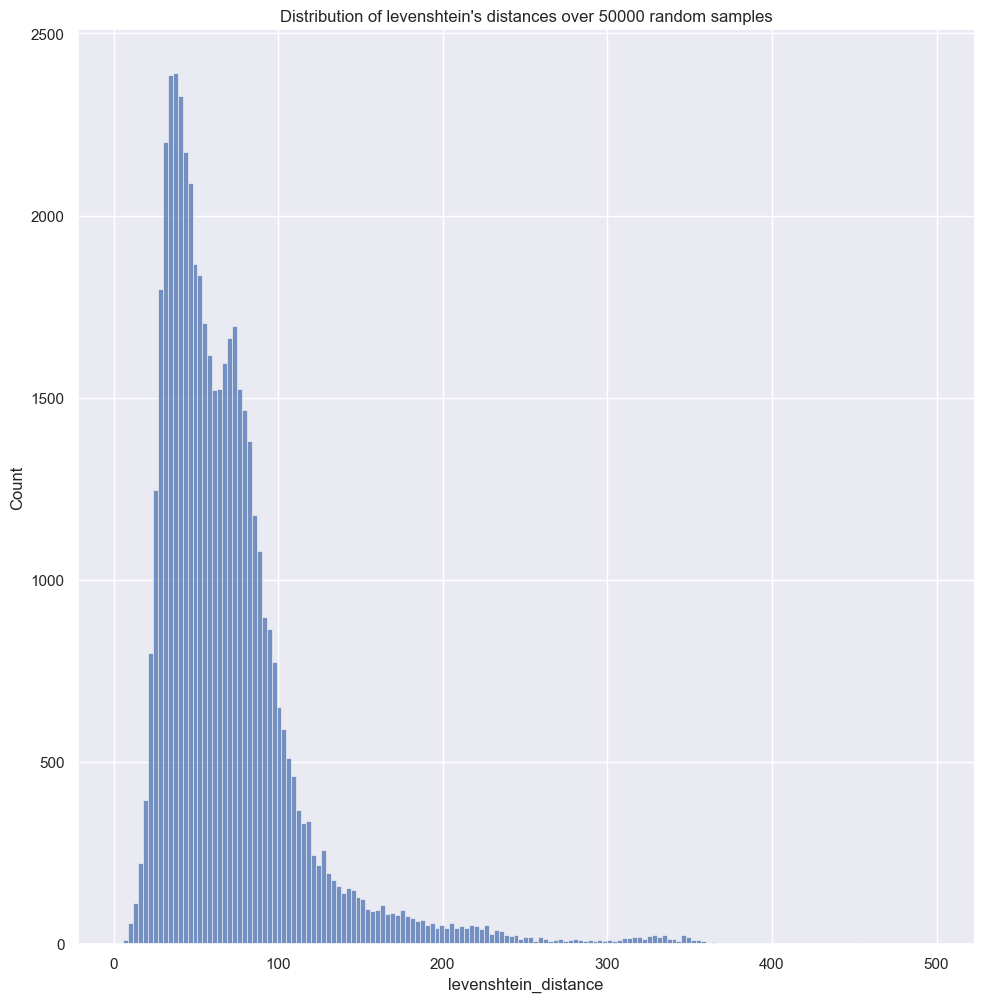

In [115]:
sns.displot(
    urls_tsdf[urls_tsdf["levenshtein_distance"] < 500],
    x="levenshtein_distance",
    binwidth=3,
    height=10,
)
plt.title(f"Distribution of levenshtein's distances over {N_SAMPLES} random samples")

## Experiments

### Unchanged URLs

Keep `urls_tdf` intact for this section to show what it should

#### DBSCAN